Experiments on the data treatment from the fitted models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from SVIModel import SVIModel
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
warnings.filterwarnings("ignore", category=UserWarning)
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress statsmodels ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

folder_path = "E:/OutputParamsFiles/OutputFiles"
files = [entry.name for entry in os.scandir(folder_path) if entry.is_file()]
# Sort files numerically based on their names
files_sorted = sorted(files, key=lambda x: int(x.split()[1].split('.')[0]))
dataFrame = pd.DataFrame(columns = ["QUOTE_UNIXTIME", "EXPIRE_UNIX", "a", "b", "rho", "m", "sigma"])

for i in range(1000):
    file_path = os.path.join(folder_path, files_sorted[i])
    imported_file = pd.read_csv(file_path, sep = ",")
    dataFrame = pd.concat([imported_file, dataFrame])

from scipy.stats import trim_mean
trimm = 0.2
# Grouping with a 30% trimmed mean
averages_df = (
    dataFrame
    .groupby("QUOTE_UNIXTIME", as_index=False)
    .agg({
        'a': lambda x: trim_mean(x, proportiontocut=trimm),
        'b': lambda x: trim_mean(x, proportiontocut=trimm),
        'rho': lambda x: trim_mean(x, proportiontocut=trimm),
        'm': lambda x: trim_mean(x, proportiontocut=trimm),
        'sigma': lambda x: trim_mean(x, proportiontocut=trimm)
    })
)

spot_price = 100
max_strike_spot_distance = 0.20
log_moneyness = np.log(np.linspace(spot_price*(1-max_strike_spot_distance), spot_price*(1+max_strike_spot_distance), 100)/spot_price)
fitted_smile = []

print(dataFrame.head())
print(averages_df.head())

  QUOTE_UNIXTIME EXPIRE_UNIX         a         b       rho         m     sigma
0     1549566660  1549659600  0.000001  0.409331 -0.036604  0.050581  0.000001
1     1549566660  1549918800  0.000001  0.304574 -0.990000  0.021313  0.000001
2     1549566660  1550091600  0.000001  0.530630 -0.049890  0.029212  0.000001
3     1549566660  1550264400  0.000001  0.316671 -0.025785  0.059380  0.000001
4     1549566660  1550610000  0.000001  0.517849 -0.037029  0.029212  0.000001
  QUOTE_UNIXTIME         a         b       rho         m     sigma
0     1546439410  0.006710  0.337339 -0.032539  0.099040  0.031081
1     1546439460  0.006113  0.381216 -0.040984  0.095579  0.017457
2     1546439520  0.003050  0.350720 -0.034024  0.102498  0.029953
3     1546439580  0.001865  0.406446 -0.054364  0.095504  0.006635
4     1546439640  0.002534  0.435755 -0.049068  0.090790  0.011769


In [52]:
def plot_rows_against_x(df, x, n_cols = 15, figsize_per_plot=(2, 2)):
    """
    Plots each row of the DataFrame against the same x-axis.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot.
    x (array-like): List, array, or Series to be used as the common x-axis.
    """
        # Calculate overall figure size
    n_rows = math.ceil(df.shape[0] / n_cols)
    total_width = n_cols * figsize_per_plot[0]
    total_height = n_rows * figsize_per_plot[1]

    
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, figsize=(total_width, total_height))  # Subplots configuration

    # Flatten axes for easy iteration (handles 2D axes array)
    axes = axes.flatten()

    # Iterate over rows
    for idx, row in df.iterrows():
        fitted = SVIModel().svi(x, 
                    df['a'][idx],
                    df['b'][idx],
                    df['rho'][idx],
                    df['m'][idx],
                    df['sigma'][idx],
                    )
        axes[idx].plot(x, fitted, marker = 'o')
        axes[idx].set_title(f"{idx}")
        axes[idx].grid(True)
        
# Remove empty subplots if any
    for i in range(df.shape[0], len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

#plot_rows_against_x(dataFrame, log_moneyness)

After visualy checking the fitted smiles let's tray to do some correlation analysis.

In [53]:
dataFrame['term_structure'] = (dataFrame['EXPIRE_UNIX'] - dataFrame['QUOTE_UNIXTIME'])/3600/24/365
#averages_df = averages_df.drop(averages_df.columns[1], axis=1)
print(dataFrame.head())
print(averages_df.head())

  QUOTE_UNIXTIME EXPIRE_UNIX         a         b       rho         m  \
0     1549566660  1549659600  0.000001  0.409331 -0.036604  0.050581   
1     1549566660  1549918800  0.000001  0.304574 -0.990000  0.021313   
2     1549566660  1550091600  0.000001  0.530630 -0.049890  0.029212   
3     1549566660  1550264400  0.000001  0.316671 -0.025785  0.059380   
4     1549566660  1550610000  0.000001  0.517849 -0.037029  0.029212   

      sigma term_structure  
0  0.000001       0.002947  
1  0.000001       0.011166  
2  0.000001       0.016646  
3  0.000001       0.022125  
4  0.000001       0.033084  
  QUOTE_UNIXTIME         a         b       rho         m     sigma
0     1546439410  0.006710  0.337339 -0.032539  0.099040  0.031081
1     1546439460  0.006113  0.381216 -0.040984  0.095579  0.017457
2     1546439520  0.003050  0.350720 -0.034024  0.102498  0.029953
3     1546439580  0.001865  0.406446 -0.054364  0.095504  0.006635
4     1546439640  0.002534  0.435755 -0.049068  0.090790  

Let's get the correlations

In [54]:
# Step 2: Compute correlation with the other columns
correlation_results = dataFrame[['term_structure', 'a', 'b', 'rho', 'm', 'sigma']].corr()
print(correlation_results)

                term_structure         a         b       rho         m  \
term_structure        1.000000 -0.005062 -0.084019  0.092386  0.264890   
a                    -0.005062  1.000000  0.030524  0.111821 -0.190550   
b                    -0.084019  0.030524  1.000000  0.117094 -0.171903   
rho                   0.092386  0.111821  0.117094  1.000000  0.309990   
m                     0.264890 -0.190550 -0.171903  0.309990  1.000000   
sigma                 0.027555  0.582118 -0.019249  0.092096 -0.018865   

                   sigma  
term_structure  0.027555  
a               0.582118  
b              -0.019249  
rho             0.092096  
m              -0.018865  
sigma           1.000000  


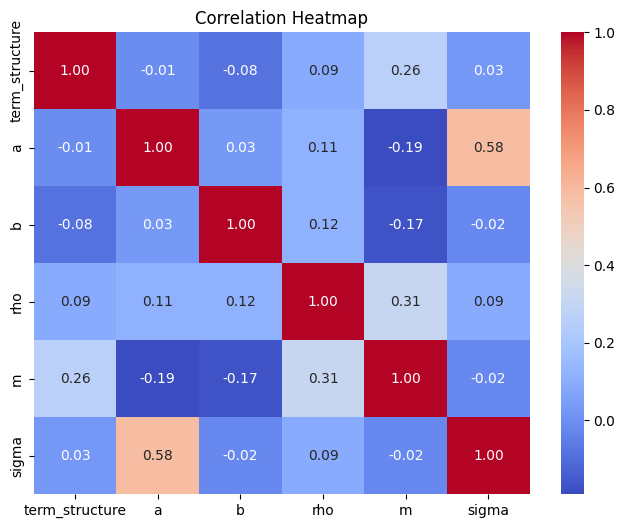

In [55]:
import seaborn as sns
# Assuming 'correlation_matrix' is your correlation matrix
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Let's analyse the auto-correlation of the params

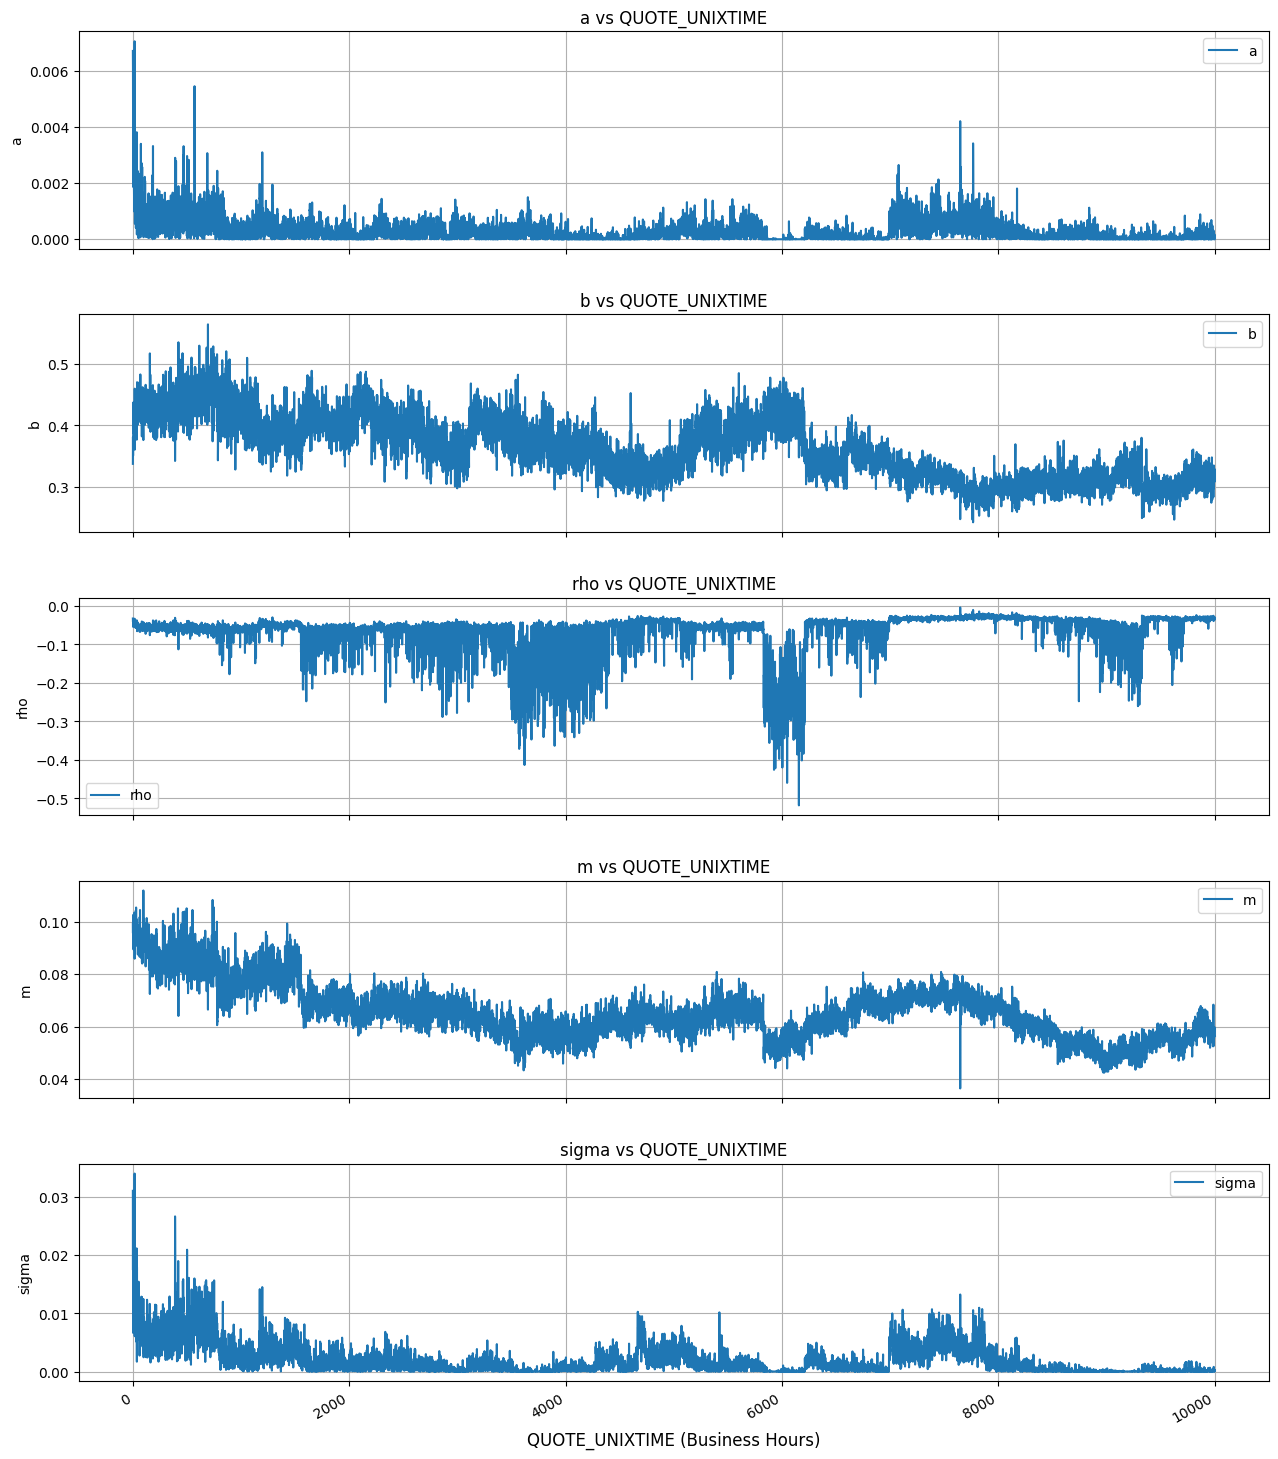

In [56]:
# Convert UNIX time to datetime format
averages_df['QUOTE_UNIXTIME'] = pd.to_datetime(averages_df['QUOTE_UNIXTIME'], unit='s')

# Create a sequential index to replace gaps (business hours only)
averages_df['Business_Hours_Index'] = range(len(averages_df))

# Define Y columns and X (compressed index)
x = averages_df['Business_Hours_Index']

# Define the list of Y-axis columns to plot
y_columns = ['a', 'b', 'rho', 'm', 'sigma']

# Create 5 subplots with a larger figure size
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 18), sharex=True)  # Increased figure size

# Plot each Y column on a separate subplot
for i, col in enumerate(y_columns):
    axes[i].plot(x, averages_df[col], linestyle='-', label=col)
    axes[i].set_title(f"{col} vs QUOTE_UNIXTIME", fontsize=12)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].grid(True)
    axes[i].legend()

# Adjust x-axis and add more space on the right
plt.subplots_adjust(right=0.95, left=0.1, top=0.95, bottom=0.05, hspace=0.3)  # Adjust spacing
axes[-1].set_xlabel("QUOTE_UNIXTIME (Business Hours)", fontsize=12)

# Format x-axis labels
fig.autofmt_xdate()

# Show the graph
plt.show()

Auto-correlation study function

In [57]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

def autocorrelation_report_with_ar(df, column_names, lags=5):
    """
    Generate autocorrelation analysis reports and fit AR models if autocorrelation is detected.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_names (list): List of column names to analyze.
    lags (int): Number of lags for ACF, PACF, and AR models. Default is 50.
    """
    for col in column_names:
        print(f"\n{'='*50}\nTime Series Analysis Report for '{col}'\n{'='*50}")
        
        # Extract the time series
        time_series = df[col].dropna()
        
        # Durbin-Watson Test
        dw_stat = durbin_watson(time_series)
        print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
        if dw_stat < 2:
            print("=> Positive autocorrelation detected.")
            autocorrelated = True
        elif dw_stat > 2:
            print("=> Negative autocorrelation detected.")
            autocorrelated = True
        else:
            print("=> No significant autocorrelation detected.")
            autocorrelated = False
        
        # ADF Test for stationarity
        adf_result = adfuller(time_series)
        print(f"\nADF Test Results:")
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        if adf_result[1] <= 0.05:
            print("=> The time series is stationary.")
        else:
            print("=> The time series is non-stationary.")
        
        # Plot ACF
        print("\nAutocorrelation Function (ACF):")
        plt.figure(figsize=(10, 4))
        plot_acf(time_series, lags=lags, title=f"ACF for {col}")
        plt.show()
        
        # Plot PACF
        print("Partial Autocorrelation Function (PACF):")
        plt.figure(figsize=(10, 4))
        plot_pacf(time_series, lags=lags, title=f"PACF for {col}")
        plt.show()

        # Fit AR model if autocorrelation is detected
        if autocorrelated:
            print("\nFitting an AR Model...")
            ar_model = AutoReg(time_series, lags=lags).fit()
            print("\nAR Model Summary:")
            print(ar_model.summary())

            # Plot AR model predictions
            predictions = ar_model.predict(start=0, end=len(time_series)-1)
            plt.figure(figsize=(10, 4))
            plt.plot(time_series, label="Original Time Series")
            plt.plot(predictions, label="AR Model Predictions", linestyle='--')
            plt.title(f"AR Model Fit for '{col}'")
            plt.legend()
            plt.show()
        else:
            print("\nNo AR model was fitted as no significant autocorrelation was detected.")
        
        print(f"\n{'='*50}\nReport Completed for '{col}'\n{'='*50}")



Time Series Analysis Report for 'a'
Durbin-Watson Statistic: 0.6409
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -6.7667
p-value: 0.0000
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

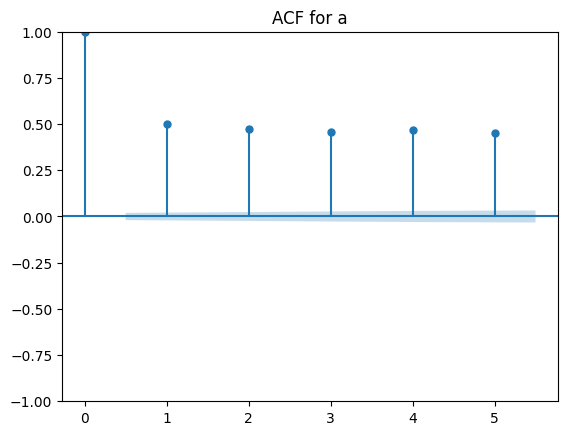

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

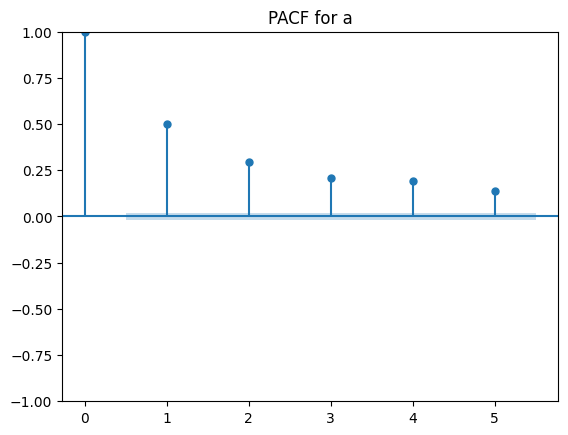


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                      a   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood               67122.610
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 17 Dec 2024   AIC                        -134231.220
Time:                        22:10:24   BIC                        -134180.751
Sample:                             5   HQIC                       -134214.136
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.438e-05   4.06e-06     13.386      0.000    4.64e-05    6.23e-05
a.L1           0.1878      0.010     18.983      0.000       0.168       0.207
a.L2     

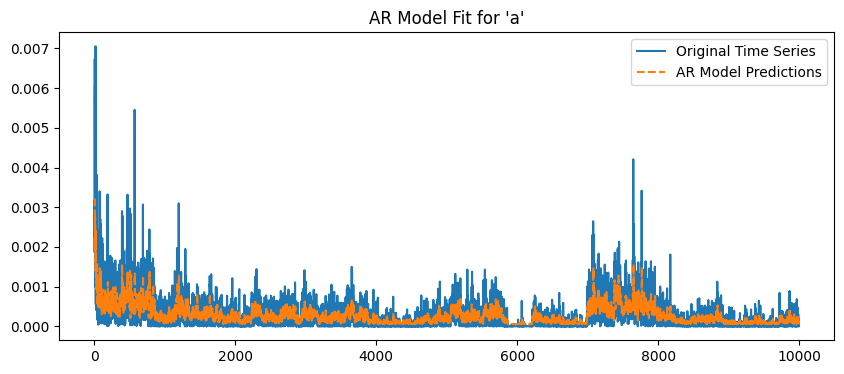


Report Completed for 'a'

Time Series Analysis Report for 'b'
Durbin-Watson Statistic: 0.0064
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -2.4811
p-value: 0.1201
=> The time series is non-stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

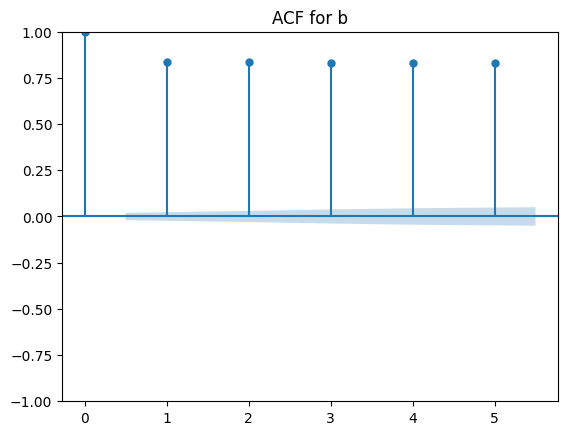

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

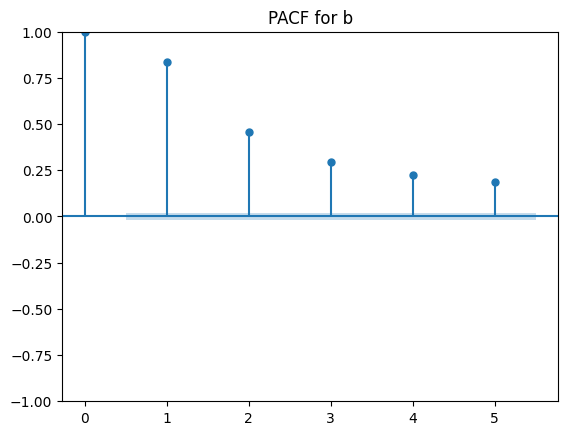


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                      b   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood               23635.462
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Tue, 17 Dec 2024   AIC                         -47256.924
Time:                        22:10:25   BIC                         -47206.455
Sample:                             5   HQIC                        -47239.840
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0143      0.002      8.137      0.000       0.011       0.018
b.L1           0.2050      0.010     20.873      0.000       0.186       0.224
b.L2     

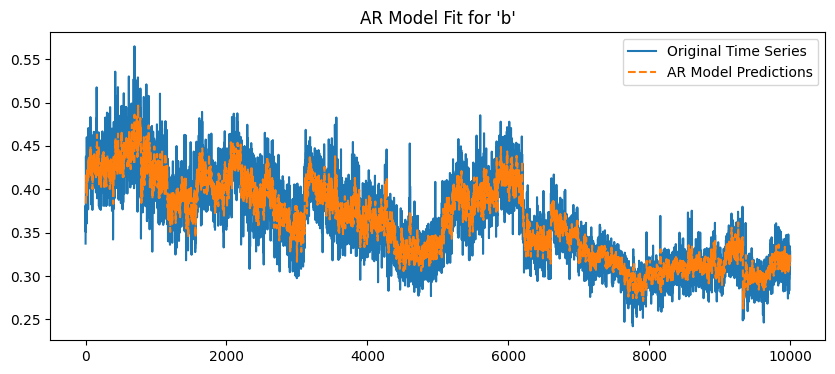


Report Completed for 'b'

Time Series Analysis Report for 'rho'
Durbin-Watson Statistic: 0.2549
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -3.9918
p-value: 0.0015
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

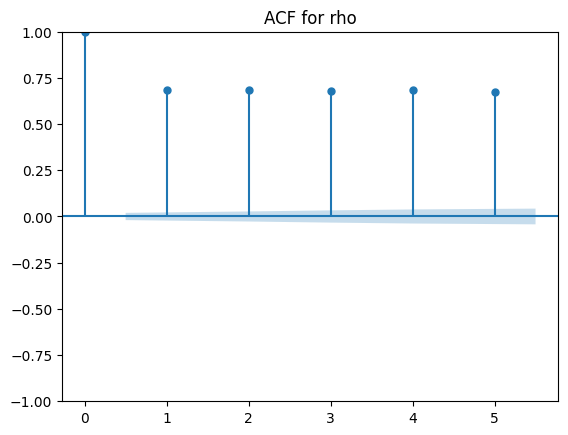

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

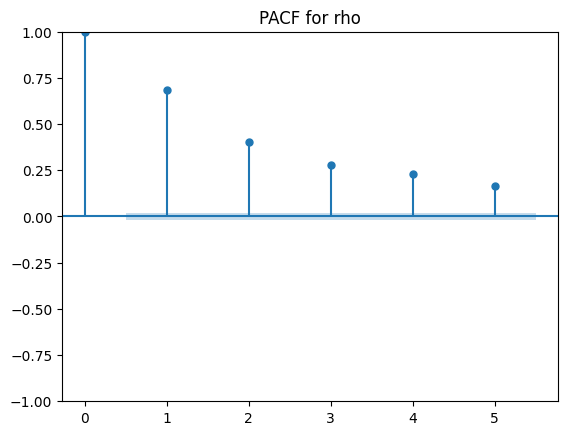


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                    rho   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood               19292.154
Method:               Conditional MLE   S.D. of innovations              0.035
Date:                Tue, 17 Dec 2024   AIC                         -38570.309
Time:                        22:10:25   BIC                         -38519.840
Sample:                             5   HQIC                        -38553.225
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0061      0.001     -9.998      0.000      -0.007      -0.005
rho.L1         0.1915      0.010     19.410      0.000       0.172       0.211
rho.L2   

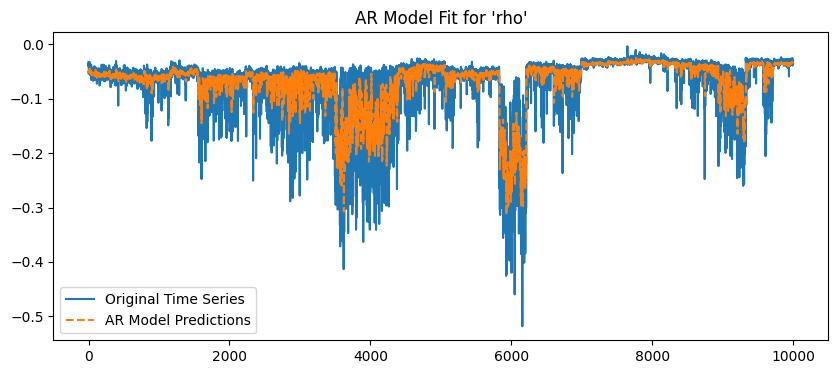


Report Completed for 'rho'

Time Series Analysis Report for 'm'
Durbin-Watson Statistic: 0.0057
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -3.2879
p-value: 0.0154
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

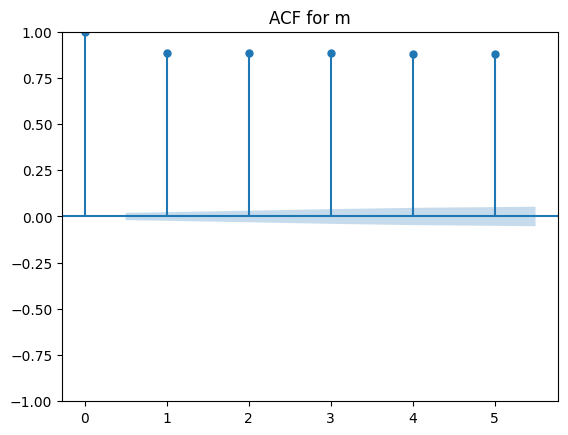

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

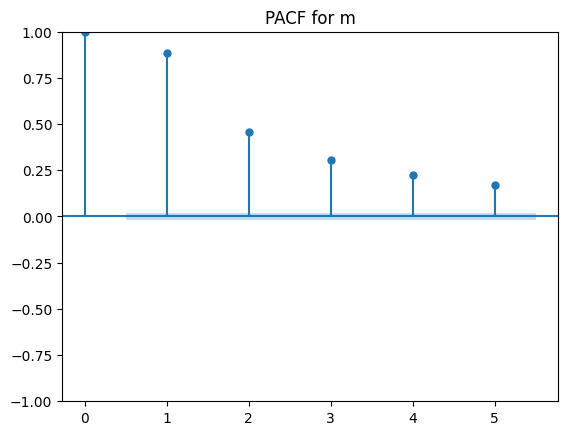


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                      m   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood               41210.640
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Tue, 17 Dec 2024   AIC                         -82407.279
Time:                        22:10:26   BIC                         -82356.811
Sample:                             5   HQIC                        -82390.196
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      7.022      0.000       0.001       0.002
m.L1           0.2267      0.010     23.011      0.000       0.207       0.246
m.L2     

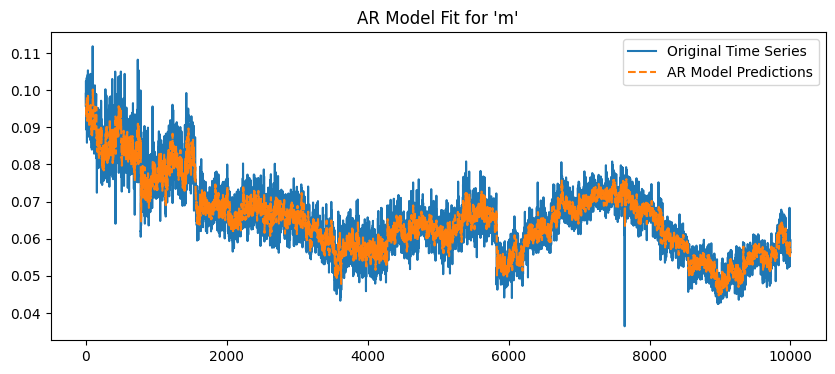


Report Completed for 'm'

Time Series Analysis Report for 'sigma'
Durbin-Watson Statistic: 0.3154
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -4.8635
p-value: 0.0000
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

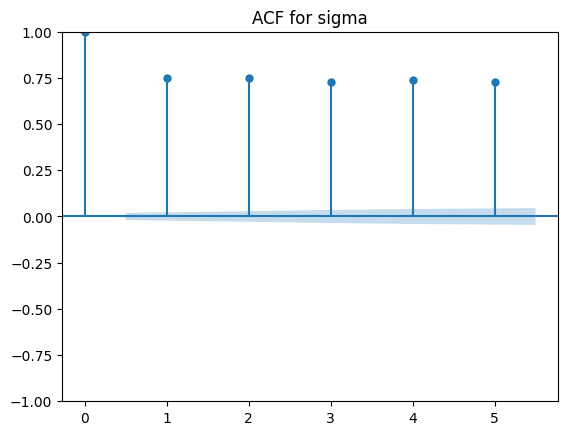

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

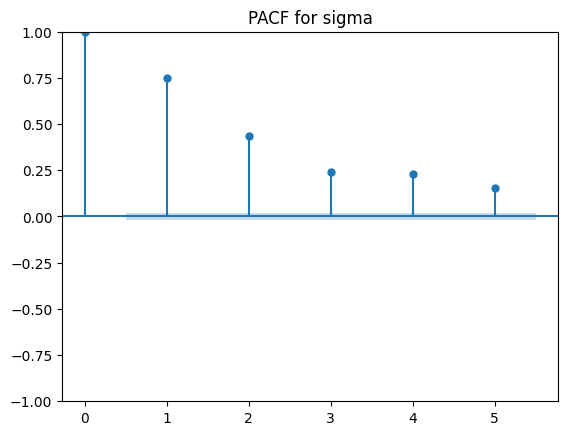


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                  sigma   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood               51413.966
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 17 Dec 2024   AIC                        -102813.932
Time:                        22:10:26   BIC                        -102763.464
Sample:                             5   HQIC                       -102796.849
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.84e-05      7.194      0.000    9.63e-05       0.000
sigma.L1       0.2136      0.010     21.657      0.000       0.194       0.233
sigma.L2 

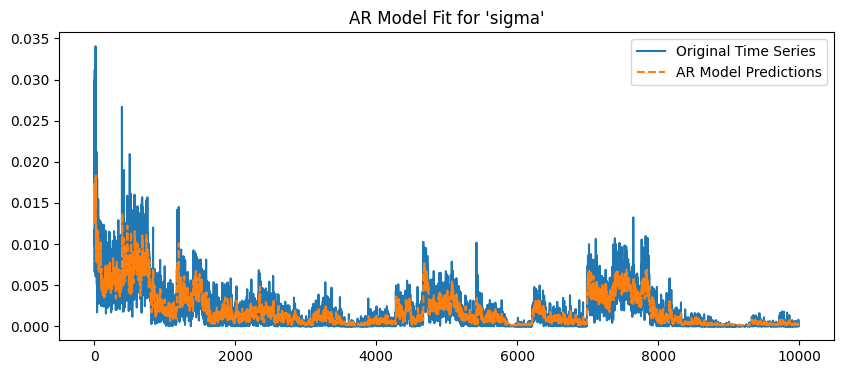


Report Completed for 'sigma'


In [58]:
# Example usage
columns_to_test = ['a', 'b', 'rho', 'm', 'sigma']
autocorrelation_report_with_ar(averages_df, columns_to_test)

Test for how much the models are better than a moving average

In [59]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import arma_order_select_ic
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def compare_ar_vs_ma(df, column_names, ma_window= 10, max_manual_lags=10):
    """
    Compare AR models with a Moving Average (MA) model for specified columns.
    Handles NaN values and generates analysis reports and plots.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_names (list): List of column names to analyze.
    ma_window (int): Window size for Moving Average.
    max_manual_lags (int): Max lags for AR model selection.
    """
    for col in column_names:
        print(f"\n{'='*50}\nTime Series Analysis Report for '{col}'\n{'='*50}")
        
        # Extract the time series and drop NaNs
        time_series = df[col].dropna()

        # Durbin-Watson Test
        dw_stat = durbin_watson(time_series)
        print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
        autocorrelated = dw_stat < 2 or dw_stat > 2
        
        # ADF Test for stationarity
        adf_result = adfuller(time_series)
        print(f"\nADF Test Results:")
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        
        # Fit AR Model with best lag selection
        print("\nFitting AR Model (Automatic Lag Selection)...")
        order_result = arma_order_select_ic(time_series, max_ar=max_manual_lags, ic='aic', trend='n')
        best_lag = order_result.aic_min_order[0]
        print(f"Best Lag (AR) based on AIC: {best_lag}")

        ar_model = AutoReg(time_series, lags=best_lag).fit()
        ar_predictions = ar_model.predict(start=0, end=len(time_series)-1)

        # Drop NaN values for RMSE calculation
        valid_idx = ~np.isnan(ar_predictions)
        ar_rmse = np.sqrt(mean_squared_error(time_series[valid_idx], ar_predictions[valid_idx]))
        print(f"AR Model RMSE: {ar_rmse:.4f}")

        # Moving Average Model
        print("\nFitting Moving Average Model...")
        ma_predictions = time_series.rolling(window=ma_window, min_periods=1).mean()

        # Drop NaN values for RMSE calculation
        valid_idx_ma = ~np.isnan(ma_predictions)
        ma_rmse = np.sqrt(mean_squared_error(time_series[valid_idx_ma], ma_predictions[valid_idx_ma]))
        print(f"Moving Average RMSE: {ma_rmse:.4f}")

        # Plot the results
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, label="Original Time Series", color="blue")
        plt.plot(ar_predictions, label="AR Model Predictions", linestyle="--", color="green")
        plt.plot(ma_predictions, label="Moving Average Predictions", linestyle="--", color="red")
        plt.title(f"AR Model vs Moving Average for '{col}'")
        plt.legend()
        plt.show()

        # Final comparison
        print(f"\nComparison for '{col}':")
        print(f"AR Model RMSE: {ar_rmse:.4f}")
        print(f"Moving Average RMSE: {ma_rmse:.4f}")
        if ar_rmse < ma_rmse:
            print("=> AR Model performs better.")
        else:
            print("=> Moving Average performs better.")

        print(f"\n{'='*50}\nReport Completed for '{col}'\n{'='*50}")




Time Series Analysis Report for 'a'
Durbin-Watson Statistic: 0.6409

ADF Test Results:
ADF Statistic: -6.7667
p-value: 0.0000

Fitting AR Model (Automatic Lag Selection)...
Best Lag (AR) based on AIC: 3
AR Model RMSE: 0.0003

Fitting Moving Average Model...
Moving Average RMSE: 0.0002


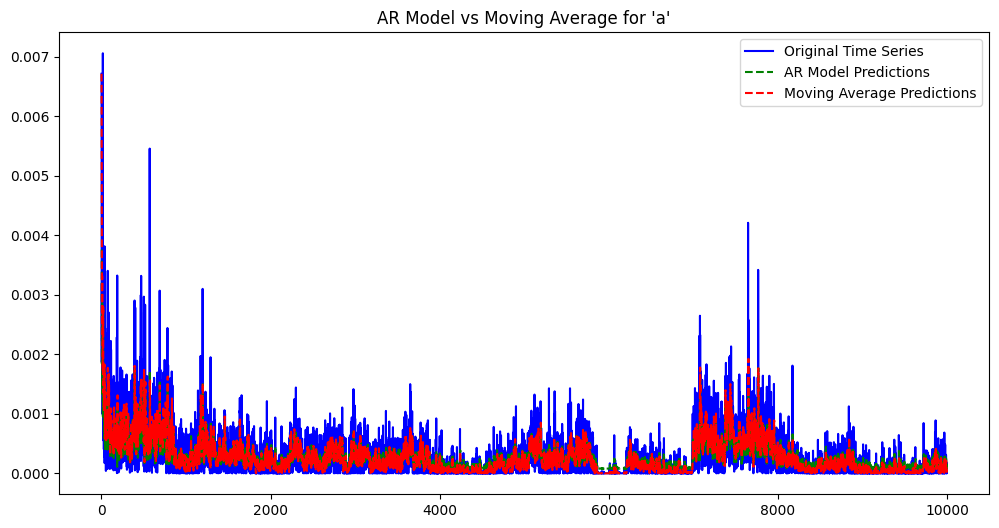


Comparison for 'a':
AR Model RMSE: 0.0003
Moving Average RMSE: 0.0002
=> Moving Average performs better.

Report Completed for 'a'

Time Series Analysis Report for 'b'
Durbin-Watson Statistic: 0.0064

ADF Test Results:
ADF Statistic: -2.4811
p-value: 0.1201

Fitting AR Model (Automatic Lag Selection)...
Best Lag (AR) based on AIC: 3
AR Model RMSE: 0.0238

Fitting Moving Average Model...
Moving Average RMSE: 0.0186


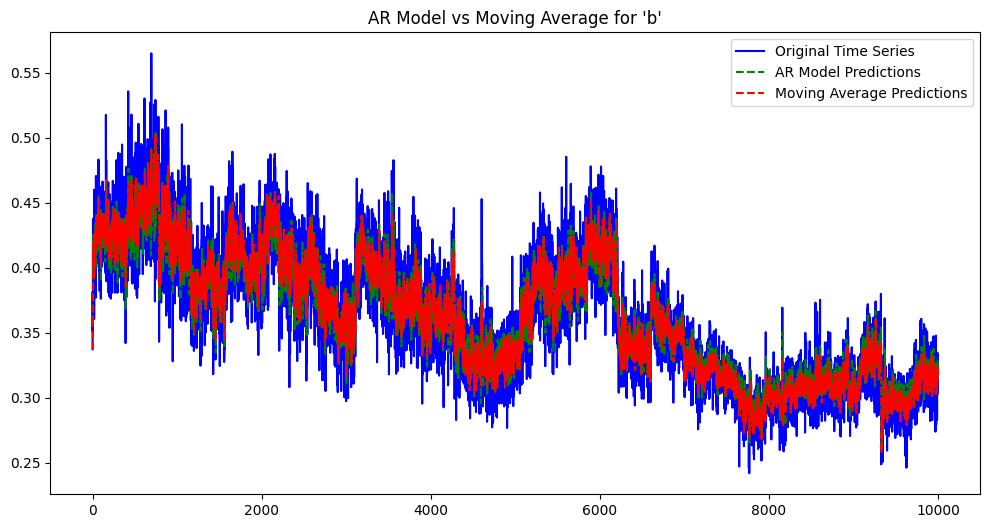


Comparison for 'b':
AR Model RMSE: 0.0238
Moving Average RMSE: 0.0186
=> Moving Average performs better.

Report Completed for 'b'

Time Series Analysis Report for 'rho'
Durbin-Watson Statistic: 0.2549

ADF Test Results:
ADF Statistic: -3.9918
p-value: 0.0015

Fitting AR Model (Automatic Lag Selection)...
Best Lag (AR) based on AIC: 1
AR Model RMSE: 0.0417

Fitting Moving Average Model...
Moving Average RMSE: 0.0288


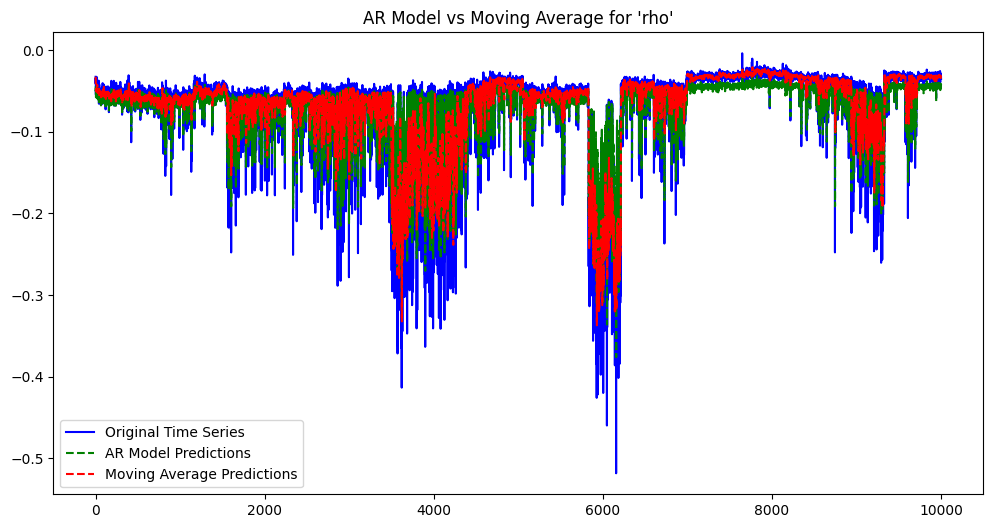


Comparison for 'rho':
AR Model RMSE: 0.0417
Moving Average RMSE: 0.0288
=> Moving Average performs better.

Report Completed for 'rho'

Time Series Analysis Report for 'm'
Durbin-Watson Statistic: 0.0057

ADF Test Results:
ADF Statistic: -3.2879
p-value: 0.0154

Fitting AR Model (Automatic Lag Selection)...
Best Lag (AR) based on AIC: 2
AR Model RMSE: 0.0043

Fitting Moving Average Model...
Moving Average RMSE: 0.0032


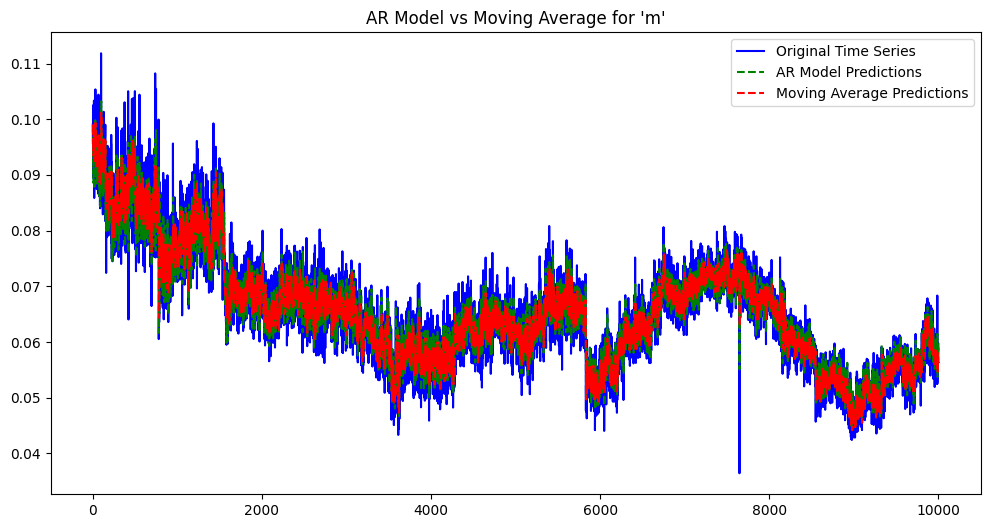


Comparison for 'm':
AR Model RMSE: 0.0043
Moving Average RMSE: 0.0032
=> Moving Average performs better.

Report Completed for 'm'

Time Series Analysis Report for 'sigma'
Durbin-Watson Statistic: 0.3154

ADF Test Results:
ADF Statistic: -4.8635
p-value: 0.0000

Fitting AR Model (Automatic Lag Selection)...
Best Lag (AR) based on AIC: 4
AR Model RMSE: 0.0014

Fitting Moving Average Model...
Moving Average RMSE: 0.0012


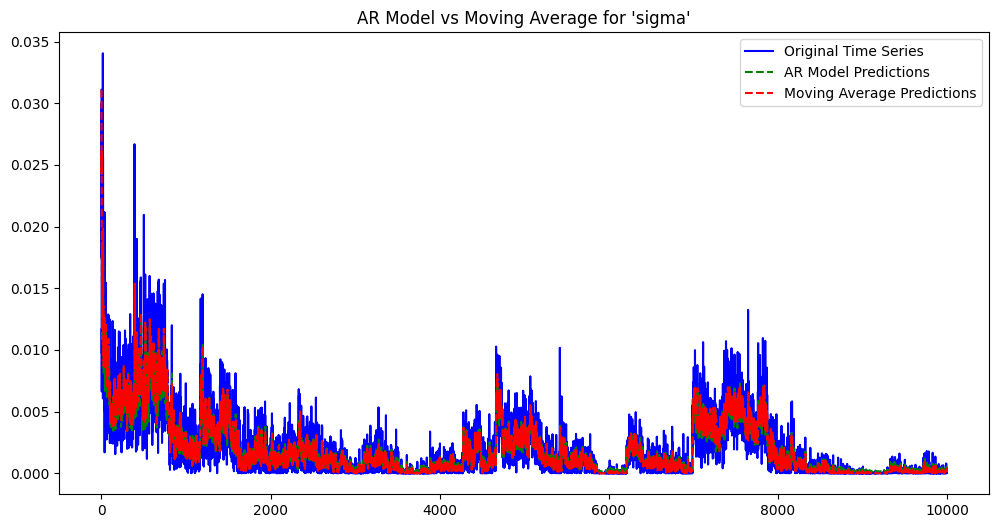


Comparison for 'sigma':
AR Model RMSE: 0.0014
Moving Average RMSE: 0.0012
=> Moving Average performs better.

Report Completed for 'sigma'


In [60]:
# Example usage
columns_to_test = ['a', 'b', 'rho', 'm', 'sigma']
compare_ar_vs_ma(averages_df, columns_to_test, ma_window=5, max_manual_lags=10)
